In [1]:
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import MmCorpus
from gensim.corpora import Dictionary
from collections import Counter, defaultdict
from numpy.random import seed
import re
from metadata.metadata import ACL_metadata
from _topic_modeling.lda_loader import Loader
import _pickle as pkl
from metadata import Gender
from _storage.storage import FileDir
import matplotlib.pyplot as plt
import numpy as np
import logging
from os.path import join
import gensim 
fd = FileDir()
seed(1)
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  

for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

Using TensorFlow backend.
/afs/inf.ed.ac.uk/user/s14/s1427590/miniconda3/envs/mlp3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
loader = Loader()

loaded corpus index from /afs/inf.ed.ac.uk/user/s14/s1427590/Honours-LDA/aan/save/acl_bow10.mm.index
initializing corpus reader from /afs/inf.ed.ac.uk/user/s14/s1427590/Honours-LDA/aan/save/acl_bow10.mm
accepted corpus with 22278 documents, 63996 features, 10941296 non-zero entries
loading LdaModel object from /afs/inf.ed.ac.uk/user/s14/s1427590/Honours-LDA/aan/save/ldaseed310lda
loading expElogbeta from /afs/inf.ed.ac.uk/user/s14/s1427590/Honours-LDA/aan/save/ldaseed310lda.expElogbeta.npy with mmap=None
loading eta from /afs/inf.ed.ac.uk/user/s14/s1427590/Honours-LDA/aan/save/ldaseed310lda.eta.npy with mmap=None
setting ignored attribute id2word to None
setting ignored attribute dispatcher to None
setting ignored attribute state to None
loaded /afs/inf.ed.ac.uk/user/s14/s1427590/Honours-LDA/aan/save/ldaseed310lda
loading LdaModel object from /afs/inf.ed.ac.uk/user/s14/s1427590/Honours-LDA/aan/save/ldaseed310lda.state
loaded /afs/inf.ed.ac.uk/user/s14/s1427590/Honours-LDA/aan/save/ldas

In [3]:
lda = loader.model
lda.id2word = loader.id2word
corpus = loader.corpus
dictionary = loader.dic
dids = loader.doc_ids
doc_topics = loader.doc_topics
topic_corresp = loader.topic_corresp
acl = ACL_metadata()
df = acl.modeling_df
topic_corresp[15] = "StatisticalParsing"

Remember to use acl.modeling_files and modeling_df for topic modeling


In [19]:
gensimcm = CoherenceModel(model=lda, corpus=corpus, dictionary=dictionary, coherence='u_mass')

In [5]:
gensimcm.get_coherence()

CorpusAccumulator accumulated stats from 1000 documents
CorpusAccumulator accumulated stats from 2000 documents
CorpusAccumulator accumulated stats from 3000 documents
CorpusAccumulator accumulated stats from 4000 documents
CorpusAccumulator accumulated stats from 5000 documents
CorpusAccumulator accumulated stats from 6000 documents
CorpusAccumulator accumulated stats from 7000 documents
CorpusAccumulator accumulated stats from 8000 documents
CorpusAccumulator accumulated stats from 9000 documents
CorpusAccumulator accumulated stats from 10000 documents
CorpusAccumulator accumulated stats from 11000 documents
CorpusAccumulator accumulated stats from 12000 documents
CorpusAccumulator accumulated stats from 13000 documents
CorpusAccumulator accumulated stats from 14000 documents
CorpusAccumulator accumulated stats from 15000 documents
CorpusAccumulator accumulated stats from 16000 documents
CorpusAccumulator accumulated stats from 17000 documents
CorpusAccumulator accumulated stats from

-1.6372640654636186

In [5]:
females_topics = []
females_topics_proportions = defaultdict(int) # P(topic|gender)'
males_topics_proportions = defaultdict(int)
fem_norm = 0 # normalizer
male_norm = 0
males_topics = []
for i, file in enumerate(acl.modeling_files):
    try:
        topics = doc_topics[i]
        gender = df.loc[acl.get_id(file)]["genders"][0] #first author
        year = int(df.loc[acl.get_id(file)]["year"])
        ## What about 1995
        if year <= 1995:
            continue
        if gender == Gender.female:
            for topic, p in topics:
                females_topics_proportions[topic_corresp[topic]] += p
            fem_norm +=1
        elif gender == Gender.male:
            for topic, p in topics:
                males_topics_proportions[topic_corresp[topic]] += p
            male_norm +=1
    except KeyError:
        pass

In [6]:
p_fem = dict()
for idx in range(100):
    f = (females_topics_proportions[topic_corresp[idx]] ) / fem_norm
    m = (males_topics_proportions[topic_corresp[idx]] ) / male_norm
    odds = (f * (1-f)) / (m * (1-m))
    p_fem[topic_corresp[idx]] = odds
    if odds > 1.5:
        print("Females are {0:.2f} more likeky than men to write about topic {1:d}".format(odds, idx))
        print("Most common words for this topic are:")
        print(topic_corresp[idx])
        for w,p in lda.show_topic(idx,10):
            print(w,)
        print("-"*30)
        print("-"*30)


Females are 1.59 more likeky than men to write about topic 1
Most common words for this topic are:
Topic 16 #Dialog
strategy
agent
evidence
conflict
proposal
accept
reject
interaction
argumentation
negotiation
------------------------------
------------------------------
Females are 1.54 more likeky than men to write about topic 9
Most common words for this topic are:
Topic 90 #LinguisticAnnotation
arabic
msa
abbreviation
dialect
habash
morphological
dialectal
write
bic
diacritic
------------------------------
------------------------------
Females are 1.91 more likeky than men to write about topic 10
Most common words for this topic are:
Topic 5 #GraphTheory+BioNLP
medical
patient
disease
clinical
drug
health
swedish
uml
symptom
disorder
------------------------------
------------------------------
Females are 1.51 more likeky than men to write about topic 40
Most common words for this topic are:
Topic 71 #Chunking/MemoryBasedModels
cue
detection
scope
negation
detect
hedge
uncertaint

In [7]:
rv_topics = dict()
for i in topic_corresp:
    rv_topics[topic_corresp[i]] = i
rv_topics

{'StatisticalParsing': 15,
 'Topic 0 #AnaphoraResolution': 65,
 'Topic 1 #MultiLingualResources': 77,
 'Topic 10 #WebSearch+Wikipedia': 87,
 'Topic 14 #SpellCorrection': 61,
 'Topic 15 #POSTagging': 0,
 'Topic 16 #Dialog': 82,
 'Topic 17 #FiniteStateModels(Automata)': 81,
 'Topic 18 #Multimodal(MainlyGeneration)': 38,
 'Topic 19 #Morphology': 27,
 'Topic 20 #MachineLearningClassification': 84,
 'Topic 21 #JapaneseNLP(notsogood)': 90,
 'Topic 22 #random(PronounsCommonnouns)': 66,
 'Topic 23 #NamedEntityRecognition': 58,
 'Topic 26 #Clustering+DistributionalSimilarity': 92,
 'Topic 27 #SyntacticTrees': 74,
 'Topic 28 #TutoringSystems': 28,
 'Topic 3 #random(commonwords)': 25,
 'Topic 31 #PPAttachment': 88,
 'Topic 32 #random(conferenceAndJournalWords)': 41,
 'Topic 33 #SpeechActs+BDI': 21,
 'Topic 36 #SpeechRecognition': 47,
 'Topic 37 #Metrics+HumanEvaluation': 29,
 'Topic 39 #SyntacticTheory': 13,
 'Topic 41 #DiscriminativeSequenceModels': 99,
 'Topic 42 #LexicalAcquisitionOfVerbSubcat

In [8]:
p_male = dict()
for idx in range(100):
    f = (females_topics_proportions[topic_corresp[idx]]) / fem_norm
    m = (males_topics_proportions[topic_corresp[idx]]) / male_norm
    odds = (m * (1-m)) / (f * (1-f))
    if odds > 1.1:
        p_male[topic_corresp[idx]] = odds
    if odds > 1.5:
        print("Males are {0:.2f} more likeky than females to write about topic {1:d}".format(odds, idx))
        print("Most common words for this topic are:")
        print(topic_corresp[idx])
        for w,p in lda.show_topic(idx,10):
            print(w,)
        print("-"*30)
        print("-"*30)


Males are 1.52 more likeky than females to write about topic 11
Most common words for this topic are:
Topic 70 #ClassicParsing
grammar
parse
parser
item
chart
terminal
parsing
free
derivation
production
------------------------------
------------------------------
Males are 1.50 more likeky than females to write about topic 26
Most common words for this topic are:
Topic 97 #ProbabilityTheory
probability
estimate
parameter
distribution
log
likelihood
probabilistic
estimation
equation
statistical
------------------------------
------------------------------
Males are 2.00 more likeky than females to write about topic 81
Most common words for this topic are:
Topic 17 #FiniteStateModels(Automata)
string
symbol
finite
transducer
transition
automaton
stack
right
regular
sequence
------------------------------
------------------------------
Males are 1.76 more likeky than females to write about topic 90
Most common words for this topic are:
Topic 21 #JapaneseNLP(notsogood)
japanese
expression

In [44]:
topics_f

[('Topic 62 #Prosody', 2.1517237747540161),
 ('Topic 5 #GraphTheory+BioNLP', 1.9237824020218526),
 ('Topic 42 #LexicalAcquisitionOfVerbSubcategorization', 1.7203386231752833),
 ('Topic 16 #Dialog', 1.6428757040446171),
 ('Topic 33 #SpeechActs+BDI', 1.6233858777894818),
 ('Topic 90 #LinguisticAnnotation', 1.6037443495532824),
 ('Topic 71 #Chunking/MemoryBasedModels', 1.5843764077410685),
 ('Topic 86 #random(French)', 1.5479090956986719),
 ('Topic 76 #Summarization', 1.5009661024266243),
 ('Topic 53 #MUCEraInformationExtraction', 1.4816071703768321),
 ('Topic 74 #TemporalIE/Aspect', 1.4721396015933359),
 ('Topic 85 #ATISdialog', 1.4143882883544221),
 ('Topic 28 #TutoringSystems', 1.4106632313837744),
 ('Topic 0 #AnaphoraResolution', 1.3756000642426647),
 ('Topic 66 #SentimentAnalysis', 1.3498874608635705),
 ('Topic 73 #random(German/Dutch)', 1.3346837519105355),
 ('Topic 7 #ConceptOntologies/KnowledgeRep', 1.2649209258747065),
 ('Topic 96 #TextCategorization', 1.2458433383228733),
 ('Top

In [9]:
x = list(range(1965,2017))
prZ_y_fem = defaultdict(lambda: [0] * len(x))
prZ_y_male = defaultdict(lambda: [0] * len(x))
normD_y_fem = [0] * len(x)
normD_y_male = [0] * len(x)
for i, file in enumerate(acl.modeling_files):
    fid = acl.get_id(file)
    data = df.loc[fid]
    year = data["year"]
    topics = doc_topics[i]
    gender = data["genders"][0] #first author
    if gender == Gender.female:
        for topic, p in topics:
            prZ_y_fem[topic_corresp[topic]][int(year) - 1965] += p
        normD_y_fem[int(year) - 1965] += 1
        
    elif gender == Gender.male:
        normD_y_male[int(year) - 1965] += 1
        for topic, p in topics:
            prZ_y_male[topic_corresp[topic]][int(year) - 1965] += p
            
for topic_name, yg in prZ_y_fem.items():
    for y in x:
        if normD_y_fem[int(y) - 1965] != 0:
            yg[int(y) - 1965]  /= normD_y_fem[int(y) - 1965]

for topic_name, yg in prZ_y_male.items():
    for y in x:
        if normD_y_male[int(y) - 1965] != 0:
            yg[int(y) - 1965]  /= normD_y_male[int(y) - 1965]
    

0 Topic 17 #FiniteStateModels(Automata)
 Finite State Models( Automata) & 0.50 & string symbol finite transducer transition automaton stack right regular sequence  \\
1 Topic 72 #CategorialGrammar/Logic
 Categorial Grammar/ Logic & 0.57 & definition variable proof logic formula property let condition description axiom  \\
3 Topic 70 #ClassicParsing
 Classic Parsing & 0.66 & grammar parse parser item chart terminal parsing free derivation production  \\
4 Topic 97 #ProbabilityTheory
 Probability Theory & 0.66 & distribution sample prior variable latent parameter bayesian inference learn posterior  \\
5 Topic 79 #AlgorithmicEfficiency
 Algorithmic Efficiency & 0.67 & length size cost entropy gram vocabulary perplexity oov long normalization  \\
6 Topic 61 #DependencyParsing
 Dependency Parsing & 0.69 & dependency parser parse treebank head tree parsing accuracy label constituent  \\
7 Topic 6 #BilingualWordAlignment
 Bilingual Word Alignment & 0.69 & alignment align link target ibm posit

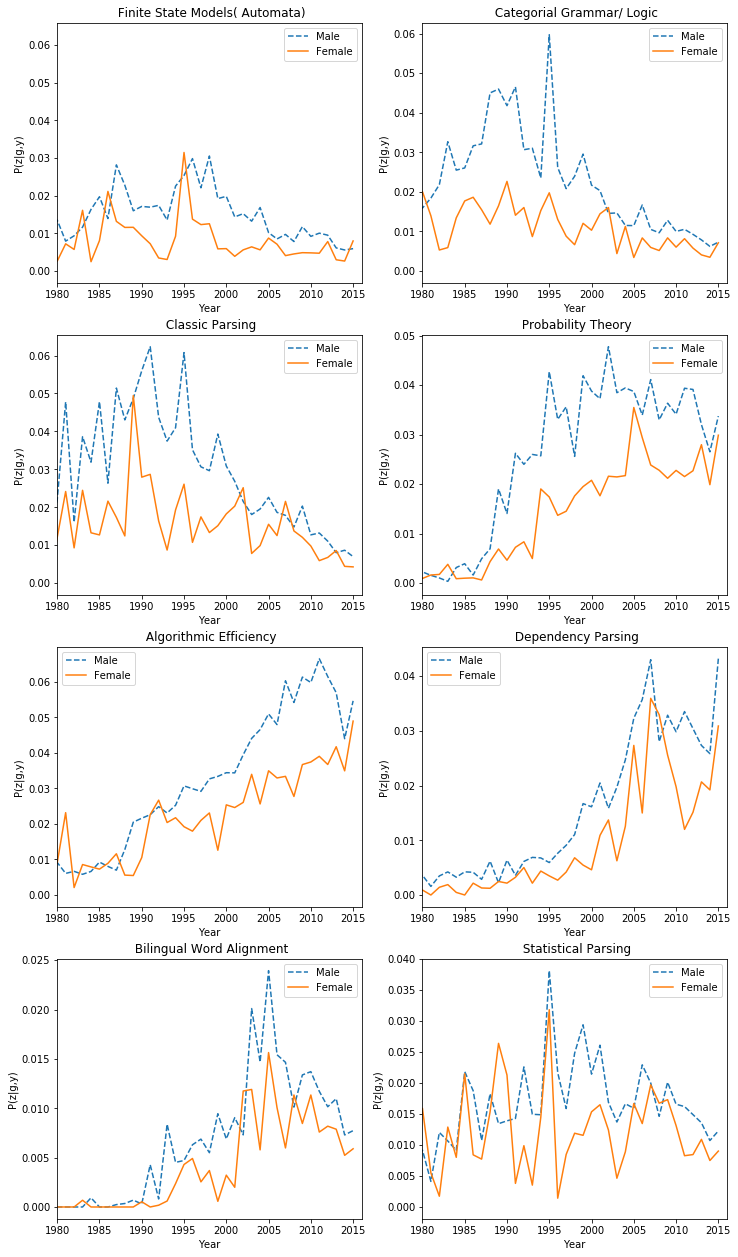

In [10]:
topics_m = list(sorted(p_fem.items(), key=lambda x: x[1]))
fig, axes  = plt.subplots(nrows=4, ncols=2, figsize=(12,22))
k = -1
for row in axes:
    for ax in row:
        k +=1
        t, score = topics_m[k]
        if "Japanese" in t:
            k+=1
            t, score = topics_m[k]
        tpc = t
        print(k, tpc)
        s = t.split(" ")[-1].replace("#","")
        q = re.sub( r"([A-Z](?=[a-z]))", r" \1", s)
        
        x = lda.show_topic(rv_topics[t], 10)
        words = ""
        for w, sc in x:
            words += (w + " ")
        print("{} & {:.2f} & {} \\\\".format(q,score,words))
        x = list(range(1965,2017))
        
        lst = prZ_y_male[tpc]
        
        st = prZ_y_male[tpc]
        ax.plot(x[:-1], lst[:-1], color=tableau20[0], linestyle="--", label="Male")
        lst = prZ_y_fem[tpc]
        ax.plot(x[:-1], lst[:-1], color=tableau20[2], label="Female")
        b=np.arange(1965, 2016, 5)
        ax.set_xlim(1980,2016)
        ax.set_title(q)
        ax.set_xlabel("Year")
        ax.set_ylabel("P(z|g,y)")
        ax.legend()
        
plt.savefig("plots/TopMaleTopics.pdf",bbox_inches="tight")

plt.show()

In [94]:
k

7

0 Topic 62 #Prosody
 Prosody & 2.15 & prosodic speaker asr pause pitch spoken accent transcript transcription duration  \\
1 Topic 5 #GraphTheory+BioNLP
 Graph Theory+ BioNLP & 1.92 & medical patient disease clinical drug health swedish uml symptom disorder  \\
2 Topic 42 #LexicalAcquisitionOfVerbSubcategorization
 Lexical Acquisition Of Verb Subcategorization & 1.72 & verb subject object construction noun verbal light preposition passive transitive  \\
3 Topic 16 #Dialog
 Dialog & 1.64 & dialogue utterance act turn conversation speaker gesture human meeting conversational  \\
4 Topic 33 #SpeechActs+BDI
 Speech Acts+BDI & 1.62 & action dialog plan goal act belief discourse speaker intention utterance  \\
5 Topic 90 #LinguisticAnnotation
 Linguistic Annotation & 1.60 & annotation annotator annotate discourse agreement scheme annotated connective label inter  \\
6 Topic 71 #Chunking/MemoryBasedModels
 Chunking/ Memory Based Models & 1.58 & cue detection scope negation detect hedge uncert

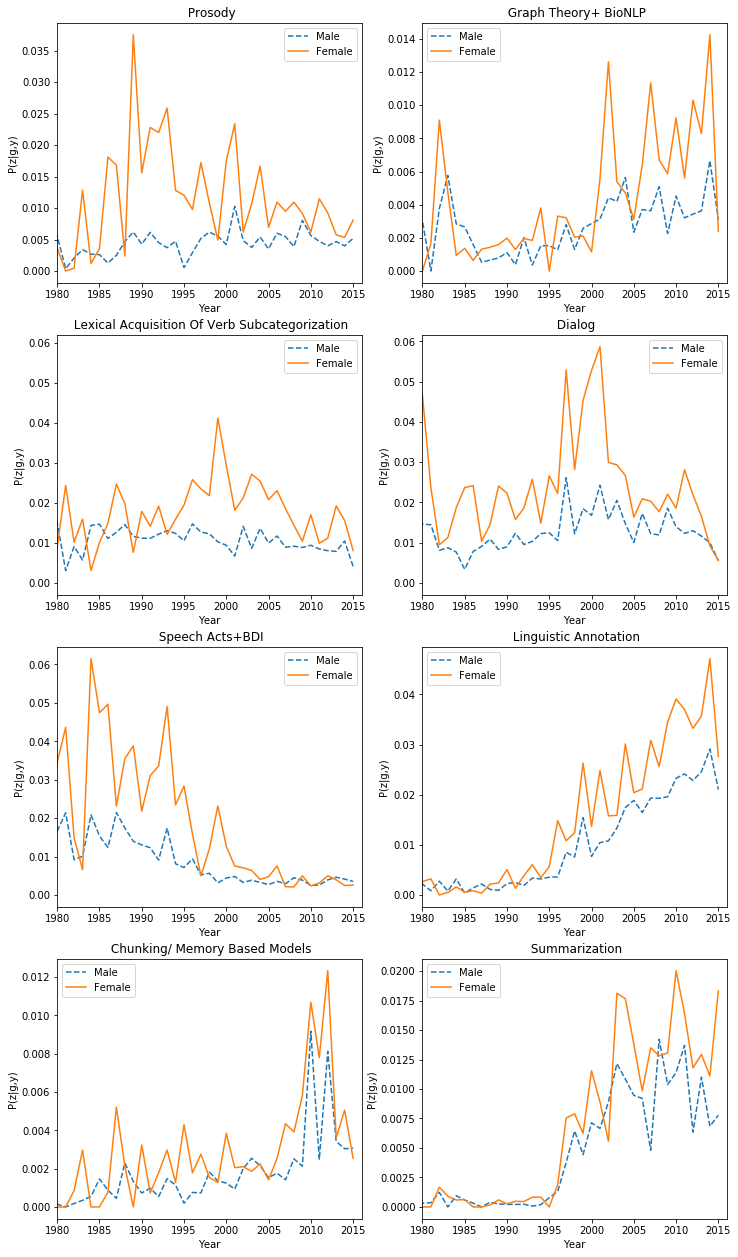

In [130]:
topics_f=list(reversed(sorted(p_fem.items(), key=lambda x: x[1])))
fig, axes  = plt.subplots(nrows=4, ncols=2, figsize=(12,22))
k = -1
for row in axes:
    for ax in row:
        k +=1
        t, score = topics_f[k]
        if "random(French)" in t:
            k+=1
            t, score = topics_f[k]
        tpc = t
        print(k, tpc)
        s = t.split(" ")[-1].replace("#","")
        q = re.sub( r"([A-Z](?=[a-z]))", r" \1", s)
        
        x = lda.show_topic(rv_topics[t], 10)
        words = ""
        for w, sc in x:
            words += (w + " ")
        print("{} & {:.2f} & {} \\\\".format(q,score,words))
        x = list(range(1965,2017))
        
        lst = prZ_y_male[tpc]
        
        st = prZ_y_male[tpc]
        ax.plot(x[:-1], lst[:-1], color=tableau20[0], linestyle="--", label="Male")
        lst = prZ_y_fem[tpc]
        ax.plot(x[:-1], lst[:-1], color=tableau20[2], label="Female")
        b=np.arange(1965, 2016, 5)
        ax.set_xlim(1980,2016)
        ax.set_title(q)
        ax.set_xlabel("Year")
        ax.set_ylabel("P(z|g,y)")
        ax.legend()
        
plt.savefig("plots/TopFemaleTopics.pdf",bbox_inches="tight")

plt.show()

In [27]:
list(reversed(sorted(p_male.items(), key=lambda x: x[1])))

[('Topic 72 #CategorialGrammar/Logic', 1.9806793459297332),
 ('Topic 17 #FiniteStateModels(Automata)', 1.9806528799682783),
 ('Topic 21 #JapaneseNLP(notsogood)', 1.8231983681186668),
 ('Topic 70 #ClassicParsing', 1.7220716286880293),
 ('Topic 97 #ProbabilityTheory', 1.5065705047932929),
 ('Topic 79 #AlgorithmicEfficiency', 1.4290839599592318),
 ('Topic 6 #BilingualWordAlignment', 1.4213175808669383),
 ('Topic 61 #DependencyParsing', 1.4168007907900133),
 ('Topic 36 #SpeechRecognition', 1.3931621488280073),
 ('StatisticalParsing', 1.3895355121171105),
 ('Topic 54 #random', 1.3802396857157904),
 ('Topic 27 #SyntacticTrees', 1.3581877021268824),
 ('Topic 56 #random', 1.3509505824974555),
 ('Topic 84 #NeuralNetworks/HumanCognition', 1.3258667876963404),
 ('Topic 32 #random(conferenceAndJournalWords)', 1.2183865463657138),
 ('Topic 15 #POSTagging', 1.2023634505614609),
 ('Topic 78 #StatisticalMachineTranslation(MorePhraseBased)',
  1.1931562688160271),
 ('Topic 41 #DiscriminativeSequenceMod

In [28]:
t = "Topic 84 #NeuralNetworks/HumanCognition"
f = (females_topics_proportions[t]) / fem_norm
m = (males_topics_proportions[t]) / male_norm
plt.scatter([0],[f])
plt.scatter([0],[m])

In [68]:
females_topics = []
females_topics_proportions = defaultdict(int) # P(topic|gender)'
males_topics_proportions = defaultdict(int)
fem_norm = 0 # normalizer
male_norm = 0
males_topics = []
for i, file in enumerate(acl.modeling_files):
    try:
        topics = doc_topics[i]
        gender = df.loc[acl.get_id(file)]["genders"][0] #first author
        year = 
        if gender == Gender.female:
            for topic, p in topics:
                females_topics_proportions[topic_corresp[topic]] += p
            fem_norm +=1
        elif gender == Gender.male:
            for topic, p in topics:
                males_topics_proportions[topic_corresp[topic]] += p
            male_norm +=1
    except KeyError:
        pass

SyntaxError: invalid syntax (<ipython-input-68-d0bff7fed61f>, line 11)

In [68]:
man_topics = list(reversed(sorted(p_male.items(), key=lambda x: x[1])))

In [80]:
def plot_topic(tpc, name=None):
    if name == None:
        name = tpc.split(" ")[-1].replace("/","-")
    fig, ax = plt.subplots(1, 1)
    lst = prZ_y_male[tpc]
    ax.plot(x[:-1], lst[:-1], color=tableau20[0], label="Male")
    lst = prZ_y_fem[tpc]
    ax.plot(x[:-1], lst[:-1], color=tableau20[2], label="Female")
    b=np.arange(1965, 2016, 5)
    ax.set_ylabel("Odds ratio")
    ax.set_xticks(b)
    ax.set_title(name)
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)    
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()  
    plt.legend()
    plt.savefig(join(fd.plots, name +".pdf"))
    plt.show()
    

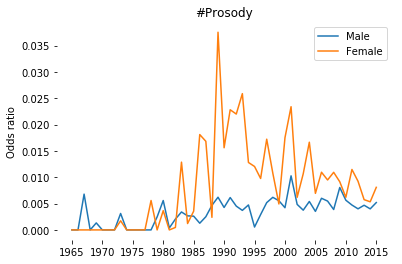

In [143]:
tpc = "Topic 62 #Prosody"
plot_topic(tpc, "#Prosody")

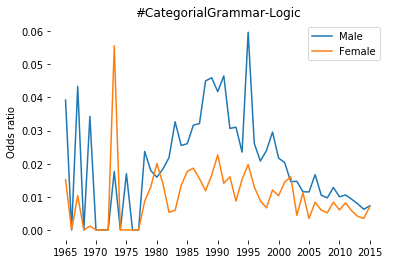

In [144]:
tpc = "Topic 72 #CategorialGrammar/Logic"
plot_topic(tpc)

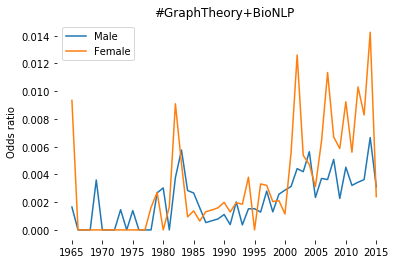

In [145]:
plot_topic("Topic 5 #GraphTheory+BioNLP")

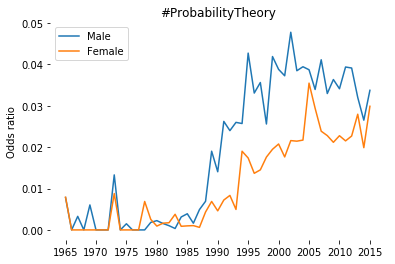

In [146]:
plot_topic("Topic 97 #ProbabilityTheory")

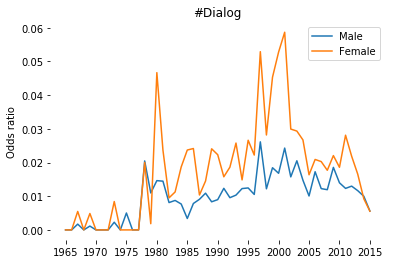

In [147]:
plot_topic("Topic 16 #Dialog")